<a href="https://colab.research.google.com/github/rer64064/PORA3/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [7]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVILGKQQLNTIWTDNGIDGLVGTGVKVVNNSIDGLTLAAFAVDSFNTDTEGDILASSKLFNSATTNPAGAPQDGTLLNVNPYAGNLYGAAAIGSYEVLGGQLNPQLWLSYLNDTGFFYALDVAYSTTIFDGINWTLKGTYLGNSLDSKMKSKDTIIATEYVGGVGTDVTGEEAMANGNLFALKGAIEVNGWDASLGGIYYGKKDKLTFNTLEDVGNLDLAGAEIFYTDGSNLNGDIGRNIFGYVTAGYTFNETVRVGADLVYGGTKTMDNSGGEKLEAVARVSYKYSPKLNFSAFYSYVNVSNDNQGQEDGRKNTVRLQALYKF' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 1 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "pdb100" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_35081_0
sequence TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVILGKQQLNTIWTDNGIDGLVGTGVKVVNNSIDGLTLAAFAVDSFNTDTEGDILASSKLFNSATTNPAGAPQDGTLLNVNPYAGNLYGAAAIGSYEVLGGQLNPQLWLSYLNDTGFFYALDVAYSTTIFDGINWTLKGTYLGNSLDSKMKSKDTIIATEYVGGVGTDVTGEEAMANGNLFALKGAIEVNGWDASLGGIYYGKKDKLTFNTLEDVGNLDLAGAEIFYTDGSNLNGDIGRNIFGYVTAGYTFNETVRVGADLVYGGTKTMDNSGGEKLEAVARVSYKYSPKLNFSAFYSYVNVSNDNQGQEDGRKNTVRLQALYKF
length 429


In [8]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 42 µs


In [9]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [10]:
#@markdown ### Advanced settings
model_type = "alphafold2_ptm" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "6" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "0.0" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "512:1024" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 4 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-06-07 08:11:40,485 Running on GPU
2025-06-07 08:11:40,490 Found 9 citations for tools or databases
2025-06-07 08:11:40,490 Query 1/1: test_35081_0 (length 429)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


2025-06-07 08:11:46,332 Sequence 0 found templates: ['5ldt_A', '5ldv_A', '5ldv_A']


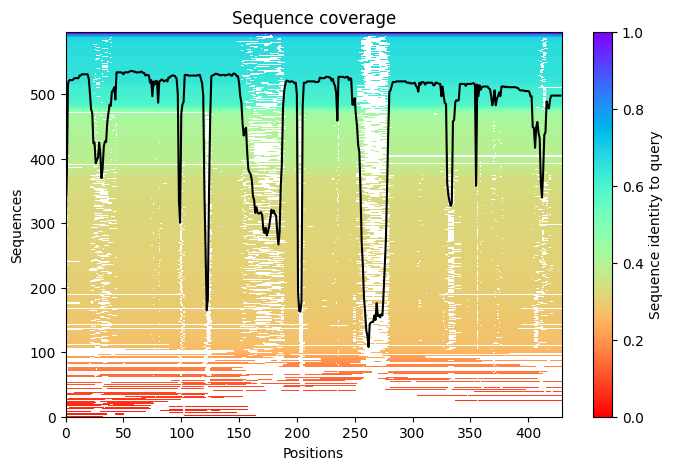

2025-06-07 08:11:47,180 Setting max_seq=512, max_extra_seq=89
2025-06-07 08:13:24,091 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=87.6 pTM=0.873
2025-06-07 08:14:06,589 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.2 pTM=0.875 tol=1.52
2025-06-07 08:14:48,915 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=88.6 pTM=0.881 tol=0.939
2025-06-07 08:15:31,421 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=90 pTM=0.888 tol=0.825
2025-06-07 08:16:13,723 alphafold2_ptm_model_1_seed_000 recycle=4 pLDDT=91.6 pTM=0.896 tol=0.441
2025-06-07 08:16:55,990 alphafold2_ptm_model_1_seed_000 recycle=5 pLDDT=92.8 pTM=0.901 tol=0.234
2025-06-07 08:17:38,490 alphafold2_ptm_model_1_seed_000 recycle=6 pLDDT=93.3 pTM=0.901 tol=0.155
2025-06-07 08:17:38,493 alphafold2_ptm_model_1_seed_000 took 334.4s (6 recycles)


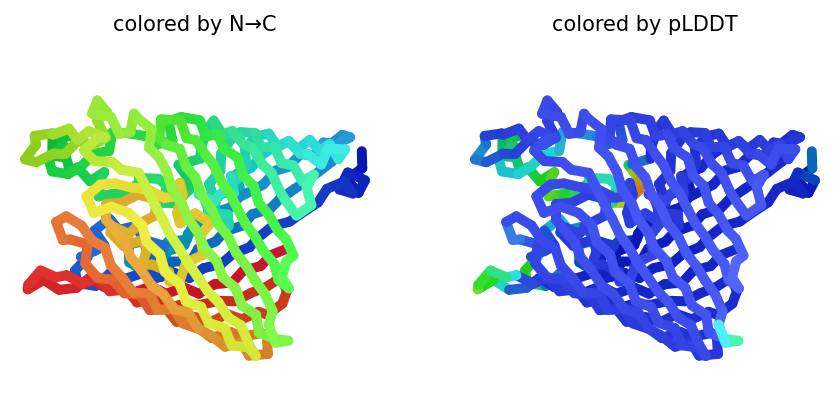

2025-06-07 08:18:21,468 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=90.2 pTM=0.89
2025-06-07 08:19:04,032 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=90.1 pTM=0.888 tol=0.57
2025-06-07 08:19:46,404 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=90.3 pTM=0.893 tol=1.53
2025-06-07 08:20:28,653 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=91.1 pTM=0.896 tol=1.27
2025-06-07 08:21:10,891 alphafold2_ptm_model_2_seed_000 recycle=4 pLDDT=91.9 pTM=0.9 tol=0.491
2025-06-07 08:21:53,562 alphafold2_ptm_model_2_seed_000 recycle=5 pLDDT=92 pTM=0.9 tol=0.253
2025-06-07 08:22:35,841 alphafold2_ptm_model_2_seed_000 recycle=6 pLDDT=93.4 pTM=0.906 tol=0.272
2025-06-07 08:22:35,842 alphafold2_ptm_model_2_seed_000 took 296.8s (6 recycles)


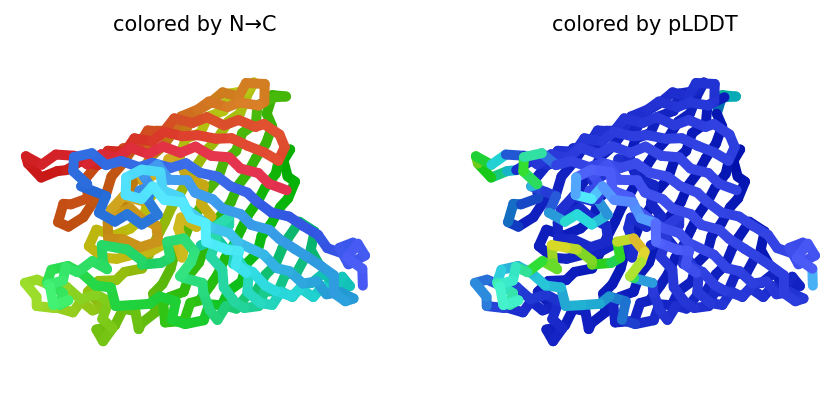

2025-06-07 08:23:40,930 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=85.6 pTM=0.861
2025-06-07 08:24:21,891 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=86.8 pTM=0.871 tol=1.08
2025-06-07 08:25:02,813 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=87.4 pTM=0.872 tol=0.794
2025-06-07 08:25:43,632 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=87.4 pTM=0.871 tol=0.386
2025-06-07 08:26:24,315 alphafold2_ptm_model_3_seed_000 recycle=4 pLDDT=89.4 pTM=0.883 tol=1.2
2025-06-07 08:27:05,306 alphafold2_ptm_model_3_seed_000 recycle=5 pLDDT=89.9 pTM=0.885 tol=0.443
2025-06-07 08:27:46,030 alphafold2_ptm_model_3_seed_000 recycle=6 pLDDT=89.9 pTM=0.885 tol=0.264
2025-06-07 08:27:46,032 alphafold2_ptm_model_3_seed_000 took 309.8s (6 recycles)


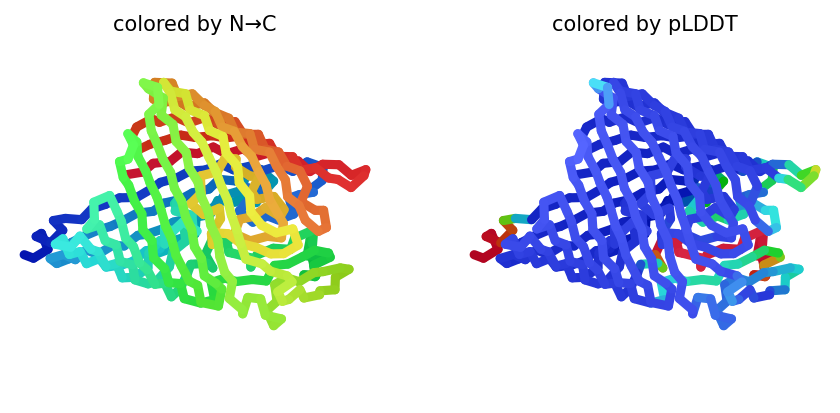

2025-06-07 08:28:26,994 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=85.9 pTM=0.859
2025-06-07 08:29:08,029 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=88.8 pTM=0.877 tol=1.22
2025-06-07 08:29:48,740 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=90.6 pTM=0.883 tol=0.475
2025-06-07 08:30:29,532 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=91.6 pTM=0.887 tol=0.309
2025-06-07 08:31:10,419 alphafold2_ptm_model_4_seed_000 recycle=4 pLDDT=92 pTM=0.886 tol=0.223
2025-06-07 08:31:51,083 alphafold2_ptm_model_4_seed_000 recycle=5 pLDDT=92.1 pTM=0.888 tol=0.198
2025-06-07 08:32:32,192 alphafold2_ptm_model_4_seed_000 recycle=6 pLDDT=92.4 pTM=0.888 tol=0.0756
2025-06-07 08:32:32,196 alphafold2_ptm_model_4_seed_000 took 285.8s (6 recycles)


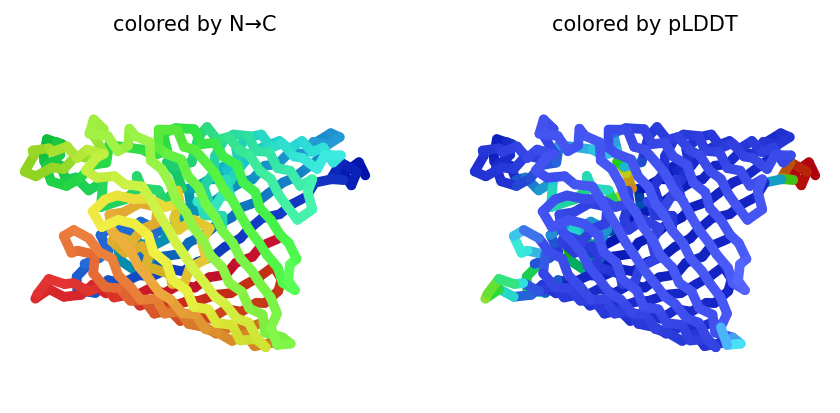

2025-06-07 08:33:13,221 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=84.1 pTM=0.851
2025-06-07 08:33:54,310 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=85.6 pTM=0.867 tol=0.846
2025-06-07 08:34:35,882 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=85.9 pTM=0.867 tol=0.845
2025-06-07 08:35:16,783 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=85.6 pTM=0.865 tol=0.909
2025-06-07 08:35:57,651 alphafold2_ptm_model_5_seed_000 recycle=4 pLDDT=85.4 pTM=0.862 tol=0.483
2025-06-07 08:36:38,334 alphafold2_ptm_model_5_seed_000 recycle=5 pLDDT=86.1 pTM=0.866 tol=1.76
2025-06-07 08:37:19,701 alphafold2_ptm_model_5_seed_000 recycle=6 pLDDT=86.7 pTM=0.869 tol=0.568
2025-06-07 08:37:19,704 alphafold2_ptm_model_5_seed_000 took 287.1s (6 recycles)


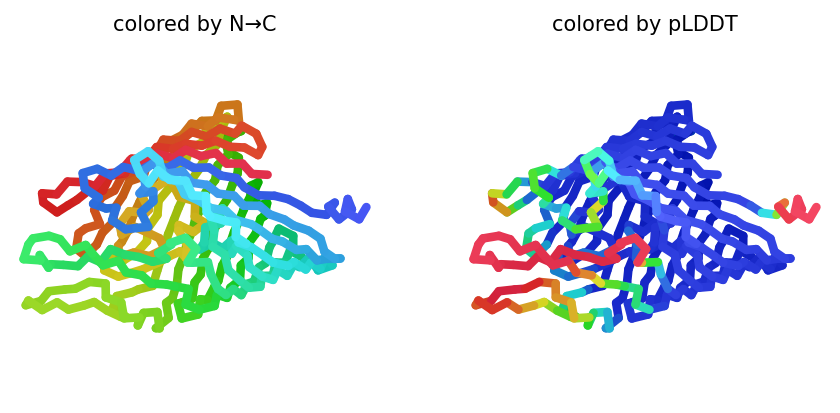

2025-06-07 08:38:05,614 alphafold2_ptm_model_1_seed_001 recycle=0 pLDDT=88.6 pTM=0.882
2025-06-07 08:38:48,244 alphafold2_ptm_model_1_seed_001 recycle=1 pLDDT=89.1 pTM=0.889 tol=1.22
2025-06-07 08:39:30,846 alphafold2_ptm_model_1_seed_001 recycle=2 pLDDT=90 pTM=0.889 tol=1.14
2025-06-07 08:40:13,008 alphafold2_ptm_model_1_seed_001 recycle=3 pLDDT=90.1 pTM=0.889 tol=0.301
2025-06-07 08:40:55,275 alphafold2_ptm_model_1_seed_001 recycle=4 pLDDT=90.6 pTM=0.892 tol=0.414
2025-06-07 08:41:37,660 alphafold2_ptm_model_1_seed_001 recycle=5 pLDDT=90.6 pTM=0.891 tol=0.346
2025-06-07 08:42:20,374 alphafold2_ptm_model_1_seed_001 recycle=6 pLDDT=91.2 pTM=0.894 tol=0.195
2025-06-07 08:42:20,386 alphafold2_ptm_model_1_seed_001 took 297.3s (6 recycles)


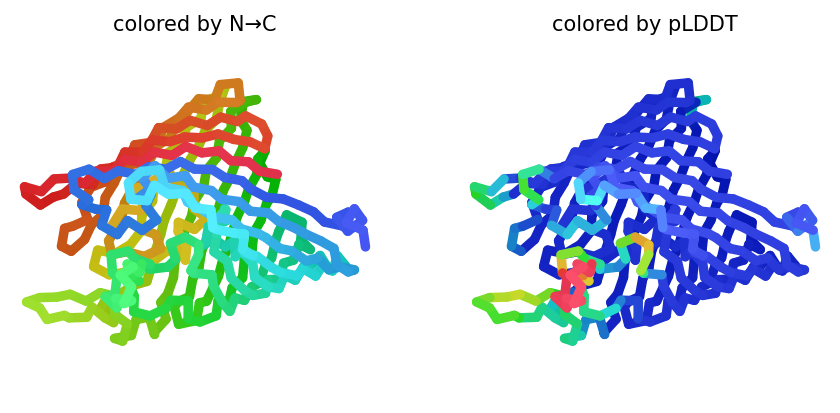

2025-06-07 08:43:03,037 alphafold2_ptm_model_2_seed_001 recycle=0 pLDDT=88.7 pTM=0.888
2025-06-07 08:43:45,776 alphafold2_ptm_model_2_seed_001 recycle=1 pLDDT=90.1 pTM=0.893 tol=1.11
2025-06-07 08:44:28,288 alphafold2_ptm_model_2_seed_001 recycle=2 pLDDT=91.1 pTM=0.897 tol=0.785
2025-06-07 08:45:10,927 alphafold2_ptm_model_2_seed_001 recycle=3 pLDDT=92.5 pTM=0.903 tol=0.748
2025-06-07 08:45:53,152 alphafold2_ptm_model_2_seed_001 recycle=4 pLDDT=93.8 pTM=0.906 tol=0.594
2025-06-07 08:46:36,309 alphafold2_ptm_model_2_seed_001 recycle=5 pLDDT=94.3 pTM=0.909 tol=0.112
2025-06-07 08:47:18,472 alphafold2_ptm_model_2_seed_001 recycle=6 pLDDT=94.4 pTM=0.909 tol=0.0538
2025-06-07 08:47:18,473 alphafold2_ptm_model_2_seed_001 took 297.7s (6 recycles)


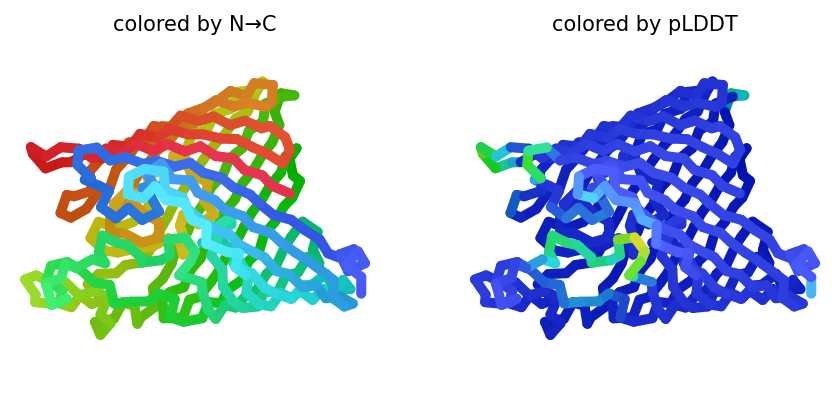

2025-06-07 08:47:59,457 alphafold2_ptm_model_3_seed_001 recycle=0 pLDDT=84.2 pTM=0.849
2025-06-07 08:48:40,377 alphafold2_ptm_model_3_seed_001 recycle=1 pLDDT=86.7 pTM=0.87 tol=1.22
2025-06-07 08:49:21,432 alphafold2_ptm_model_3_seed_001 recycle=2 pLDDT=87.6 pTM=0.872 tol=0.884
2025-06-07 08:50:02,122 alphafold2_ptm_model_3_seed_001 recycle=3 pLDDT=89.7 pTM=0.883 tol=1.11
2025-06-07 08:50:43,052 alphafold2_ptm_model_3_seed_001 recycle=4 pLDDT=90.8 pTM=0.888 tol=0.403
2025-06-07 08:51:24,504 alphafold2_ptm_model_3_seed_001 recycle=5 pLDDT=91.3 pTM=0.889 tol=0.54
2025-06-07 08:52:05,621 alphafold2_ptm_model_3_seed_001 recycle=6 pLDDT=91.8 pTM=0.894 tol=0.485
2025-06-07 08:52:05,624 alphafold2_ptm_model_3_seed_001 took 286.7s (6 recycles)


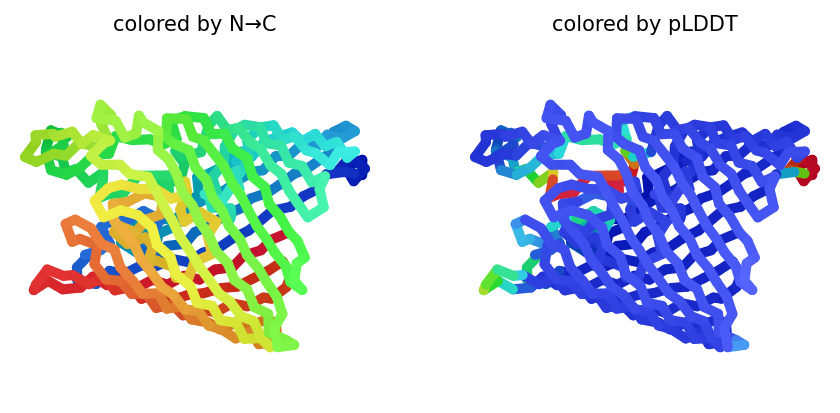

2025-06-07 08:52:46,754 alphafold2_ptm_model_4_seed_001 recycle=0 pLDDT=84.7 pTM=0.848
2025-06-07 08:53:27,523 alphafold2_ptm_model_4_seed_001 recycle=1 pLDDT=86.9 pTM=0.868 tol=1.77
2025-06-07 08:54:08,241 alphafold2_ptm_model_4_seed_001 recycle=2 pLDDT=88.2 pTM=0.874 tol=0.983
2025-06-07 08:54:49,706 alphafold2_ptm_model_4_seed_001 recycle=3 pLDDT=88.5 pTM=0.873 tol=0.661
2025-06-07 08:55:30,273 alphafold2_ptm_model_4_seed_001 recycle=4 pLDDT=88.9 pTM=0.874 tol=0.735
2025-06-07 08:56:11,241 alphafold2_ptm_model_4_seed_001 recycle=5 pLDDT=89.4 pTM=0.876 tol=0.431
2025-06-07 08:56:52,326 alphafold2_ptm_model_4_seed_001 recycle=6 pLDDT=89.4 pTM=0.875 tol=0.245
2025-06-07 08:56:52,329 alphafold2_ptm_model_4_seed_001 took 286.3s (6 recycles)


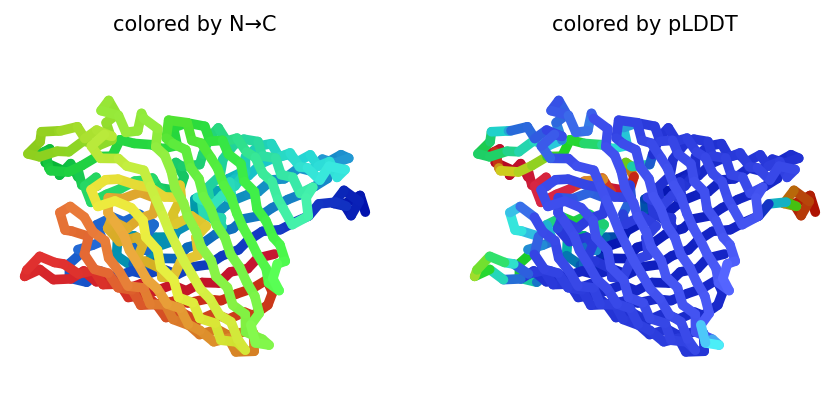

2025-06-07 08:57:33,482 alphafold2_ptm_model_5_seed_001 recycle=0 pLDDT=84.6 pTM=0.851
2025-06-07 08:58:14,341 alphafold2_ptm_model_5_seed_001 recycle=1 pLDDT=86 pTM=0.87 tol=1.32
2025-06-07 08:58:55,839 alphafold2_ptm_model_5_seed_001 recycle=2 pLDDT=86.1 pTM=0.868 tol=0.675
2025-06-07 08:59:36,521 alphafold2_ptm_model_5_seed_001 recycle=3 pLDDT=85.1 pTM=0.855 tol=0.476
2025-06-07 09:00:17,401 alphafold2_ptm_model_5_seed_001 recycle=4 pLDDT=85.9 pTM=0.865 tol=1.14
2025-06-07 09:00:58,025 alphafold2_ptm_model_5_seed_001 recycle=5 pLDDT=85.9 pTM=0.864 tol=0.37
2025-06-07 09:01:39,095 alphafold2_ptm_model_5_seed_001 recycle=6 pLDDT=86.1 pTM=0.864 tol=0.529
2025-06-07 09:01:39,099 alphafold2_ptm_model_5_seed_001 took 286.4s (6 recycles)


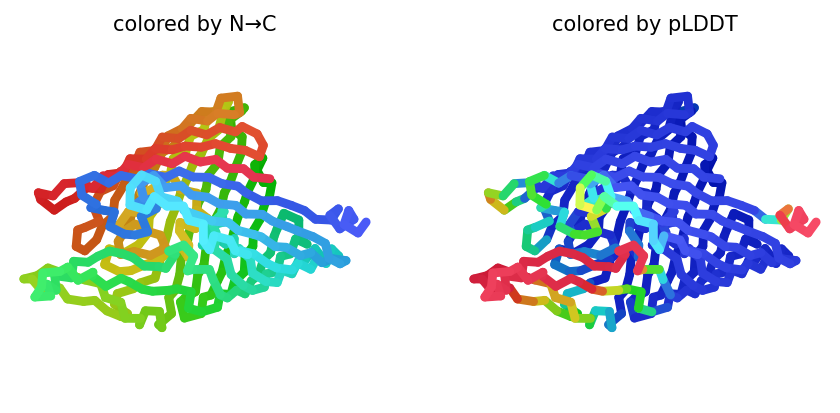

2025-06-07 09:02:24,729 alphafold2_ptm_model_1_seed_002 recycle=0 pLDDT=87.8 pTM=0.878
2025-06-07 09:03:06,843 alphafold2_ptm_model_1_seed_002 recycle=1 pLDDT=88.9 pTM=0.889 tol=1.07
2025-06-07 09:03:49,176 alphafold2_ptm_model_1_seed_002 recycle=2 pLDDT=88.9 pTM=0.887 tol=0.352
2025-06-07 09:04:31,351 alphafold2_ptm_model_1_seed_002 recycle=3 pLDDT=88.5 pTM=0.885 tol=1.49
2025-06-07 09:05:13,510 alphafold2_ptm_model_1_seed_002 recycle=4 pLDDT=89.4 pTM=0.89 tol=0.801
2025-06-07 09:05:55,702 alphafold2_ptm_model_1_seed_002 recycle=5 pLDDT=89.4 pTM=0.889 tol=0.661
2025-06-07 09:06:37,838 alphafold2_ptm_model_1_seed_002 recycle=6 pLDDT=90.4 pTM=0.894 tol=0.425
2025-06-07 09:06:37,840 alphafold2_ptm_model_1_seed_002 took 295.4s (6 recycles)


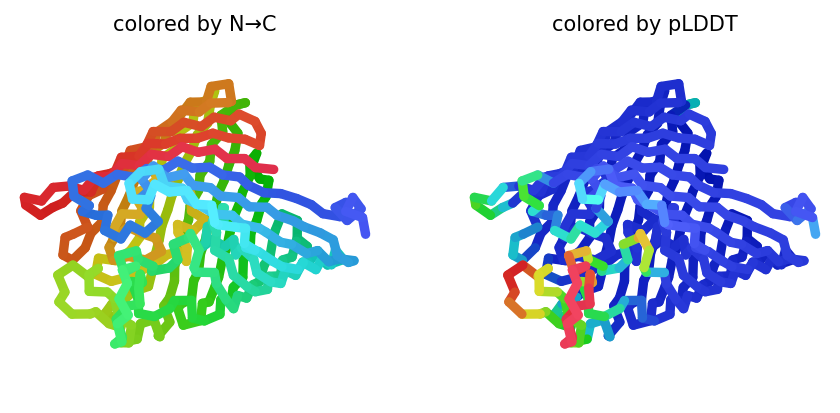

2025-06-07 09:07:20,357 alphafold2_ptm_model_2_seed_002 recycle=0 pLDDT=88.1 pTM=0.882
2025-06-07 09:08:03,006 alphafold2_ptm_model_2_seed_002 recycle=1 pLDDT=89.3 pTM=0.89 tol=0.935
2025-06-07 09:08:45,246 alphafold2_ptm_model_2_seed_002 recycle=2 pLDDT=90.6 pTM=0.893 tol=0.733
2025-06-07 09:09:27,751 alphafold2_ptm_model_2_seed_002 recycle=3 pLDDT=90.9 pTM=0.896 tol=0.426
2025-06-07 09:10:09,942 alphafold2_ptm_model_2_seed_002 recycle=4 pLDDT=91.2 pTM=0.897 tol=0.358
2025-06-07 09:10:52,430 alphafold2_ptm_model_2_seed_002 recycle=5 pLDDT=91.1 pTM=0.896 tol=0.153
2025-06-07 09:11:34,671 alphafold2_ptm_model_2_seed_002 recycle=6 pLDDT=91.6 pTM=0.9 tol=0.178
2025-06-07 09:11:34,672 alphafold2_ptm_model_2_seed_002 took 296.4s (6 recycles)


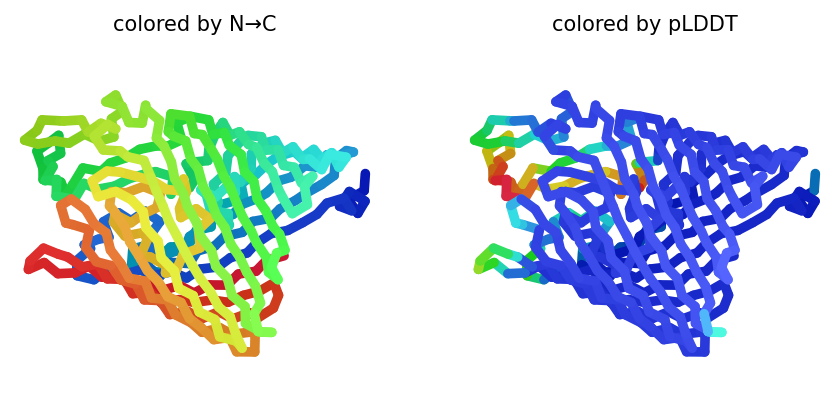

2025-06-07 09:12:15,679 alphafold2_ptm_model_3_seed_002 recycle=0 pLDDT=86.4 pTM=0.867
2025-06-07 09:12:56,348 alphafold2_ptm_model_3_seed_002 recycle=1 pLDDT=88.4 pTM=0.884 tol=0.852
2025-06-07 09:13:37,306 alphafold2_ptm_model_3_seed_002 recycle=2 pLDDT=89.7 pTM=0.89 tol=0.42
2025-06-07 09:14:17,992 alphafold2_ptm_model_3_seed_002 recycle=3 pLDDT=89.9 pTM=0.891 tol=0.299
2025-06-07 09:14:58,699 alphafold2_ptm_model_3_seed_002 recycle=4 pLDDT=90.2 pTM=0.895 tol=0.196
2025-06-07 09:15:39,638 alphafold2_ptm_model_3_seed_002 recycle=5 pLDDT=90.4 pTM=0.894 tol=0.167
2025-06-07 09:16:20,670 alphafold2_ptm_model_3_seed_002 recycle=6 pLDDT=90.7 pTM=0.895 tol=0.179
2025-06-07 09:16:20,674 alphafold2_ptm_model_3_seed_002 took 285.6s (6 recycles)


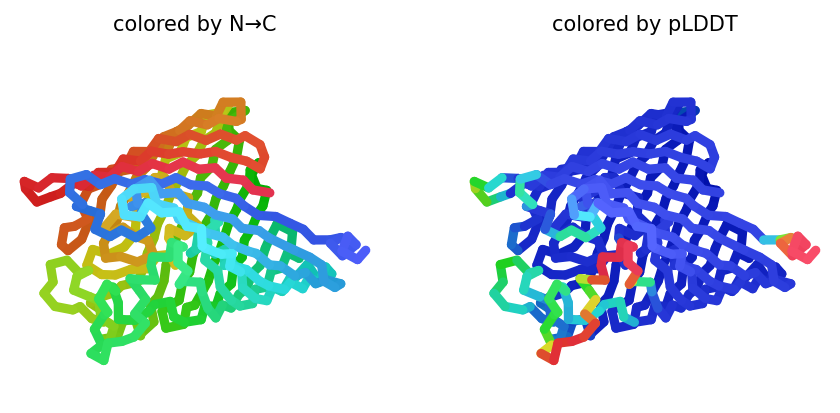

2025-06-07 09:17:01,915 alphafold2_ptm_model_4_seed_002 recycle=0 pLDDT=86.1 pTM=0.854
2025-06-07 09:17:42,745 alphafold2_ptm_model_4_seed_002 recycle=1 pLDDT=88.3 pTM=0.875 tol=0.728
2025-06-07 09:18:23,637 alphafold2_ptm_model_4_seed_002 recycle=2 pLDDT=88.6 pTM=0.874 tol=0.611
2025-06-07 09:19:04,758 alphafold2_ptm_model_4_seed_002 recycle=3 pLDDT=88.6 pTM=0.875 tol=0.364
2025-06-07 09:19:45,424 alphafold2_ptm_model_4_seed_002 recycle=4 pLDDT=88.9 pTM=0.874 tol=0.353
2025-06-07 09:20:26,039 alphafold2_ptm_model_4_seed_002 recycle=5 pLDDT=89 pTM=0.874 tol=0.145
2025-06-07 09:21:06,655 alphafold2_ptm_model_4_seed_002 recycle=6 pLDDT=89.2 pTM=0.875 tol=0.167
2025-06-07 09:21:06,656 alphafold2_ptm_model_4_seed_002 took 285.3s (6 recycles)


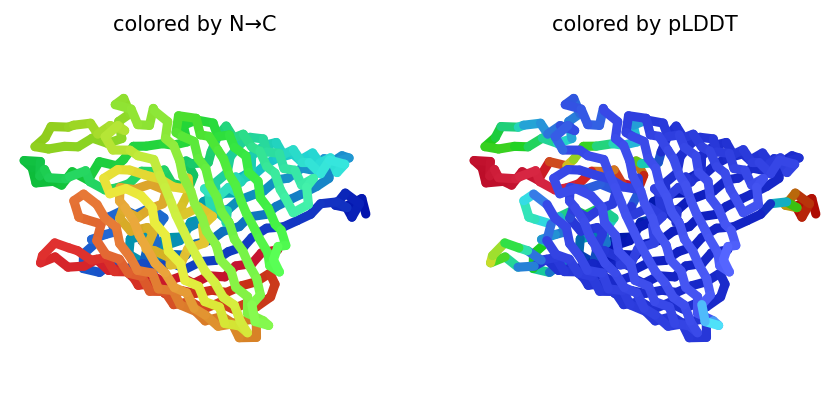

2025-06-07 09:21:47,622 alphafold2_ptm_model_5_seed_002 recycle=0 pLDDT=84.3 pTM=0.854
2025-06-07 09:22:28,270 alphafold2_ptm_model_5_seed_002 recycle=1 pLDDT=86.2 pTM=0.87 tol=1.29
2025-06-07 09:23:08,905 alphafold2_ptm_model_5_seed_002 recycle=2 pLDDT=85.6 pTM=0.865 tol=1.15
2025-06-07 09:23:49,566 alphafold2_ptm_model_5_seed_002 recycle=3 pLDDT=85.7 pTM=0.866 tol=1
2025-06-07 09:24:30,417 alphafold2_ptm_model_5_seed_002 recycle=4 pLDDT=86.4 pTM=0.869 tol=1.52
2025-06-07 09:25:11,018 alphafold2_ptm_model_5_seed_002 recycle=5 pLDDT=86.4 pTM=0.865 tol=0.289
2025-06-07 09:25:51,681 alphafold2_ptm_model_5_seed_002 recycle=6 pLDDT=86.9 pTM=0.869 tol=0.452
2025-06-07 09:25:51,682 alphafold2_ptm_model_5_seed_002 took 284.6s (6 recycles)


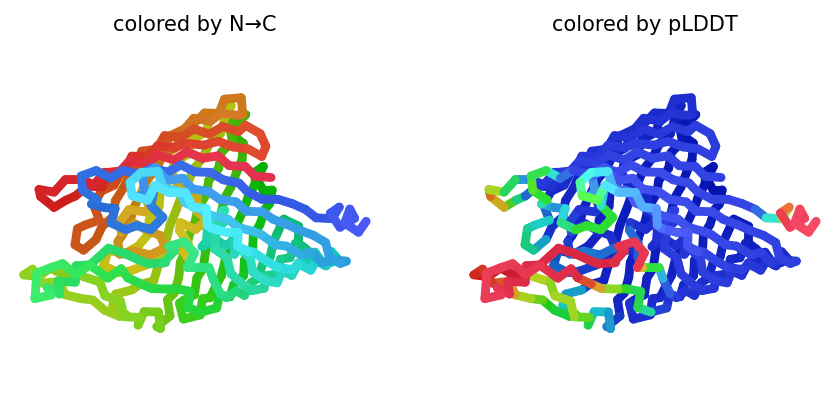

2025-06-07 09:26:38,071 alphafold2_ptm_model_1_seed_003 recycle=0 pLDDT=88.1 pTM=0.879
2025-06-07 09:27:20,276 alphafold2_ptm_model_1_seed_003 recycle=1 pLDDT=88.2 pTM=0.886 tol=0.725
2025-06-07 09:28:02,412 alphafold2_ptm_model_1_seed_003 recycle=2 pLDDT=89.8 pTM=0.892 tol=0.57
2025-06-07 09:28:44,904 alphafold2_ptm_model_1_seed_003 recycle=3 pLDDT=89.6 pTM=0.891 tol=0.736
2025-06-07 09:29:27,332 alphafold2_ptm_model_1_seed_003 recycle=4 pLDDT=89.4 pTM=0.889 tol=1.36
2025-06-07 09:30:09,682 alphafold2_ptm_model_1_seed_003 recycle=5 pLDDT=89.7 pTM=0.89 tol=0.689
2025-06-07 09:30:52,086 alphafold2_ptm_model_1_seed_003 recycle=6 pLDDT=89.9 pTM=0.892 tol=0.581
2025-06-07 09:30:52,087 alphafold2_ptm_model_1_seed_003 took 296.2s (6 recycles)


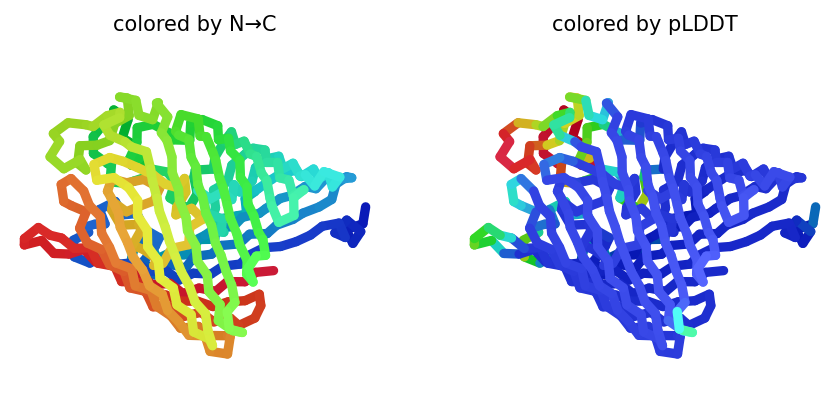

2025-06-07 09:31:34,659 alphafold2_ptm_model_2_seed_003 recycle=0 pLDDT=88.6 pTM=0.886
2025-06-07 09:32:16,827 alphafold2_ptm_model_2_seed_003 recycle=1 pLDDT=90.1 pTM=0.898 tol=1.12
2025-06-07 09:32:58,994 alphafold2_ptm_model_2_seed_003 recycle=2 pLDDT=90.7 pTM=0.899 tol=1.06
2025-06-07 09:33:41,389 alphafold2_ptm_model_2_seed_003 recycle=3 pLDDT=90.6 pTM=0.898 tol=0.281
2025-06-07 09:34:23,611 alphafold2_ptm_model_2_seed_003 recycle=4 pLDDT=90.6 pTM=0.895 tol=0.65
2025-06-07 09:35:05,822 alphafold2_ptm_model_2_seed_003 recycle=5 pLDDT=90.9 pTM=0.896 tol=1.08
2025-06-07 09:35:48,218 alphafold2_ptm_model_2_seed_003 recycle=6 pLDDT=91.9 pTM=0.904 tol=0.955
2025-06-07 09:35:48,222 alphafold2_ptm_model_2_seed_003 took 295.7s (6 recycles)


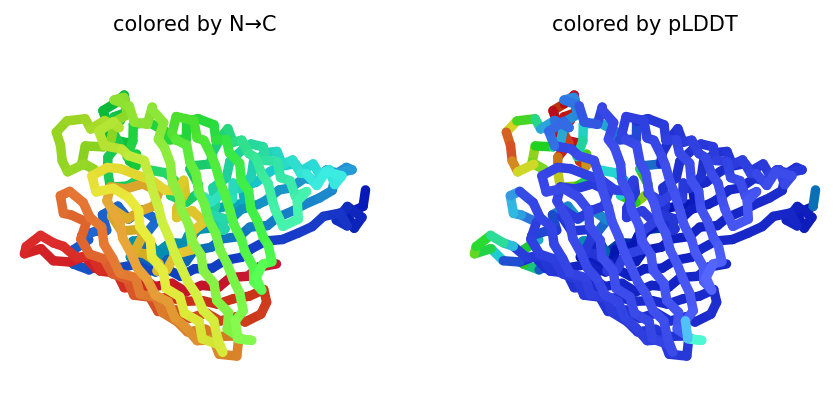

2025-06-07 09:36:29,441 alphafold2_ptm_model_3_seed_003 recycle=0 pLDDT=86.8 pTM=0.865
2025-06-07 09:37:10,421 alphafold2_ptm_model_3_seed_003 recycle=1 pLDDT=88.8 pTM=0.886 tol=1.06
2025-06-07 09:37:51,088 alphafold2_ptm_model_3_seed_003 recycle=2 pLDDT=89.7 pTM=0.89 tol=0.429
2025-06-07 09:38:31,743 alphafold2_ptm_model_3_seed_003 recycle=3 pLDDT=89.9 pTM=0.892 tol=0.257
2025-06-07 09:39:12,474 alphafold2_ptm_model_3_seed_003 recycle=4 pLDDT=89.9 pTM=0.891 tol=0.286
2025-06-07 09:39:53,183 alphafold2_ptm_model_3_seed_003 recycle=5 pLDDT=90.1 pTM=0.891 tol=0.117
2025-06-07 09:40:33,940 alphafold2_ptm_model_3_seed_003 recycle=6 pLDDT=90.2 pTM=0.894 tol=0.139
2025-06-07 09:40:33,944 alphafold2_ptm_model_3_seed_003 took 285.1s (6 recycles)


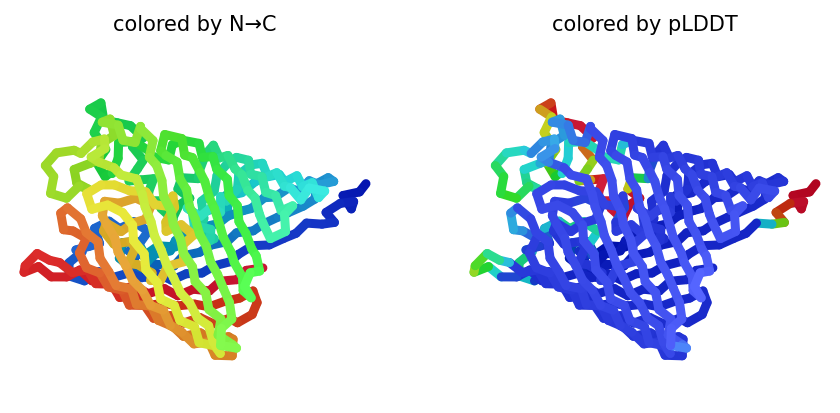

2025-06-07 09:41:15,353 alphafold2_ptm_model_4_seed_003 recycle=0 pLDDT=85.1 pTM=0.852
2025-06-07 09:41:56,089 alphafold2_ptm_model_4_seed_003 recycle=1 pLDDT=87 pTM=0.869 tol=0.885
2025-06-07 09:42:36,889 alphafold2_ptm_model_4_seed_003 recycle=2 pLDDT=87.8 pTM=0.872 tol=1.18
2025-06-07 09:43:17,749 alphafold2_ptm_model_4_seed_003 recycle=3 pLDDT=88.4 pTM=0.875 tol=0.223
2025-06-07 09:43:58,395 alphafold2_ptm_model_4_seed_003 recycle=4 pLDDT=88.2 pTM=0.873 tol=0.567
2025-06-07 09:44:39,199 alphafold2_ptm_model_4_seed_003 recycle=5 pLDDT=88.6 pTM=0.875 tol=0.437
2025-06-07 09:45:19,830 alphafold2_ptm_model_4_seed_003 recycle=6 pLDDT=89.1 pTM=0.879 tol=0.141
2025-06-07 09:45:19,831 alphafold2_ptm_model_4_seed_003 took 285.1s (6 recycles)


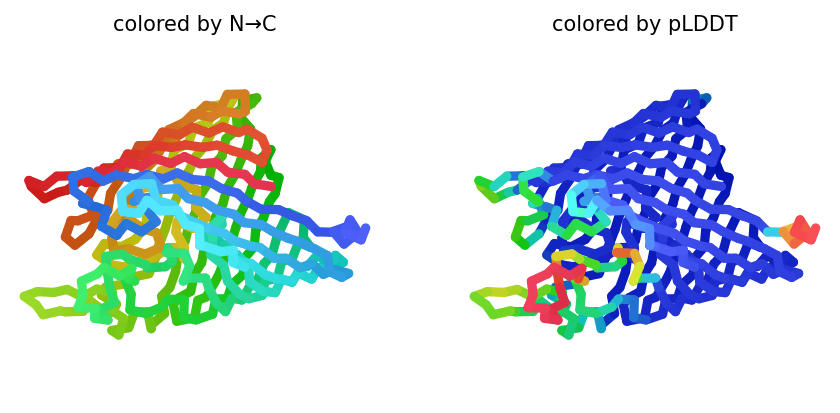

2025-06-07 09:46:00,761 alphafold2_ptm_model_5_seed_003 recycle=0 pLDDT=84.6 pTM=0.853
2025-06-07 09:46:41,624 alphafold2_ptm_model_5_seed_003 recycle=1 pLDDT=86.4 pTM=0.872 tol=1.62
2025-06-07 09:47:22,289 alphafold2_ptm_model_5_seed_003 recycle=2 pLDDT=86.6 pTM=0.875 tol=0.799
2025-06-07 09:48:03,090 alphafold2_ptm_model_5_seed_003 recycle=3 pLDDT=86.1 pTM=0.868 tol=0.417
2025-06-07 09:48:43,726 alphafold2_ptm_model_5_seed_003 recycle=4 pLDDT=85.8 pTM=0.863 tol=1.12
2025-06-07 09:49:24,694 alphafold2_ptm_model_5_seed_003 recycle=5 pLDDT=86.1 pTM=0.864 tol=0.581
2025-06-07 09:50:05,482 alphafold2_ptm_model_5_seed_003 recycle=6 pLDDT=86.4 pTM=0.867 tol=0.463
2025-06-07 09:50:05,483 alphafold2_ptm_model_5_seed_003 took 285.2s (6 recycles)


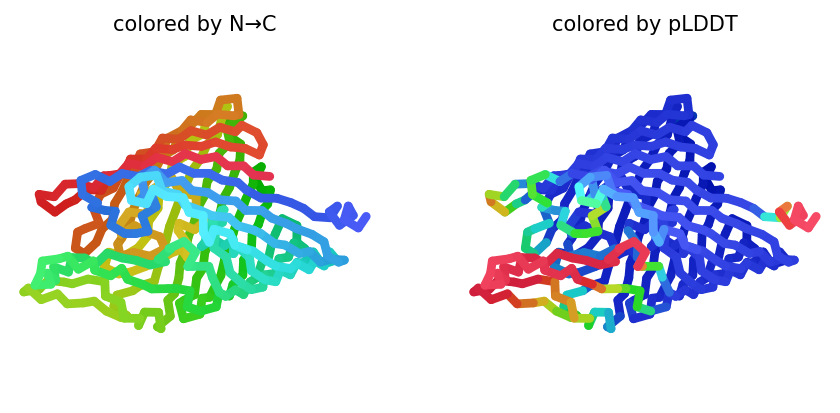

2025-06-07 09:50:05,882 reranking models by 'plddt' metric
2025-06-07 09:50:44,312 Relaxation took 38.4s
2025-06-07 09:50:44,312 rank_001_alphafold2_ptm_model_2_seed_001 pLDDT=94.4 pTM=0.909
2025-06-07 09:50:44,312 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=93.4 pTM=0.906
2025-06-07 09:50:44,313 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=93.3 pTM=0.901
2025-06-07 09:50:44,313 rank_004_alphafold2_ptm_model_4_seed_000 pLDDT=92.4 pTM=0.888
2025-06-07 09:50:44,313 rank_005_alphafold2_ptm_model_2_seed_003 pLDDT=91.9 pTM=0.904
2025-06-07 09:50:44,313 rank_006_alphafold2_ptm_model_3_seed_001 pLDDT=91.8 pTM=0.894
2025-06-07 09:50:44,313 rank_007_alphafold2_ptm_model_2_seed_002 pLDDT=91.6 pTM=0.9
2025-06-07 09:50:44,313 rank_008_alphafold2_ptm_model_1_seed_001 pLDDT=91.2 pTM=0.894
2025-06-07 09:50:44,313 rank_009_alphafold2_ptm_model_3_seed_002 pLDDT=90.7 pTM=0.895
2025-06-07 09:50:44,313 rank_010_alphafold2_ptm_model_1_seed_002 pLDDT=90.4 pTM=0.894
2025-06-07 09:50:44,314 rank_011_alph

0

In [11]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [12]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
